In [1]:
# import numpy.linalg as la
# import matplotlib as mpl
# import matplotlib.lines as mlines
# from matplotlib.patches import Ellipse
# import matplotlib.gridspec as gridspec
# import scipy.stats
# import scipy.linalg as linalg
# from scipy.stats import gaussian_kde
# from scipy.spatial.distance import squareform, pdist
# from scipy.stats import spearmanr, pearsonr, entropy
# from fastcluster import linkage
# from sklearn.preprocessing import StandardScaler
# from skimage import measure
# import torch.linalg


# Load Packages
from Functions_comparisons import *
from sklearn.datasets import load_wine
from sklearn.preprocessing import StandardScaler
import pandas as pd
import numpy as np
import time
import pickle
import random
import os
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
from matplotlib.lines import Line2D
from matplotlib.ticker import MaxNLocator
from mpl_toolkits.axes_grid1 import make_axes_locatable
import seaborn as sns
import h5py
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset
from sklearn.cluster import KMeans
from scipy.optimize import linear_sum_assignment
import libpysal
from esda.moran import Moran
from scipy.spatial import ConvexHull
from shapely.geometry import Polygon
from itertools import combinations

# Set plot default
sns.set_style("whitegrid", {'axes.grid': False})
plt.rcParams["axes.grid"] = False

import warnings
warnings.filterwarnings('ignore')

## Comparative Analyses

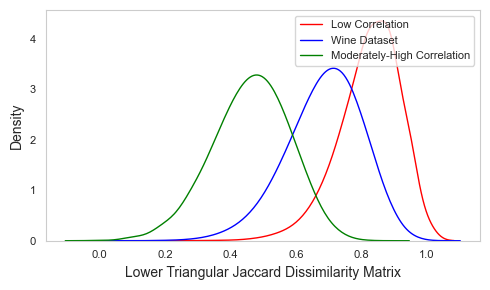

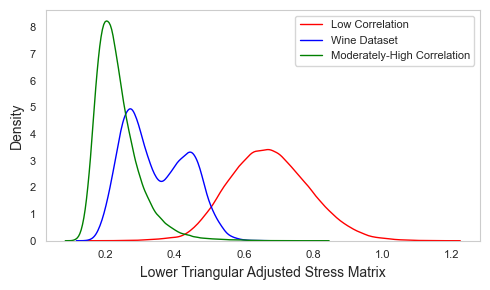

In [2]:
# Compare KDE over bookends(i.e., correlation 0 and 1) and wine dataset
#Load saved lower triangular matrices for the sorted stress matrices excluding diagonal and visualize via kde
jaccard_corr_0 = np.load(os.getcwd() + '\Data Files' + '\jaccard_array_corr_0.npy')
jaccard_wine = np.load(os.getcwd() + '\Data Files' + '\jaccard_array_wine.npy')
jaccard_corr_1 = np.load(os.getcwd() + '\Data Files' + '\jaccard_array_corr_1.npy')

stress_corr_0 = np.load(os.getcwd() + '\Data Files' + '\stress_array_corr_0.npy')
stress_wine = np.load(os.getcwd() + '\Data Files' + '\stress_array_wine.npy')
stress_corr_1 = np.load(os.getcwd() + '\Data Files' + '\stress_array_corr_1.npy')

#Curate jaccard arrays for all scenarios/case studies
jaccard_dictionary = {
    'Low Correlation': jaccard_corr_0, # No Correlation
    'Wine Dataset': jaccard_wine,
    'Moderately-High Correlation': jaccard_corr_1 # Perfect Correlation
}

stress_dictionary = {
    'Low Correlation': stress_corr_0,
    'Wine Dataset': stress_wine,
    'Moderately-High Correlation': stress_corr_1
}

compare_kde(jaccard_dictionary, x_label='Lower Triangular Jaccard Dissimilarity Matrix', bandwidth=0.3)
compare_kde(stress_dictionary, x_label='Lower Triangular Adjusted Stress Matrix')

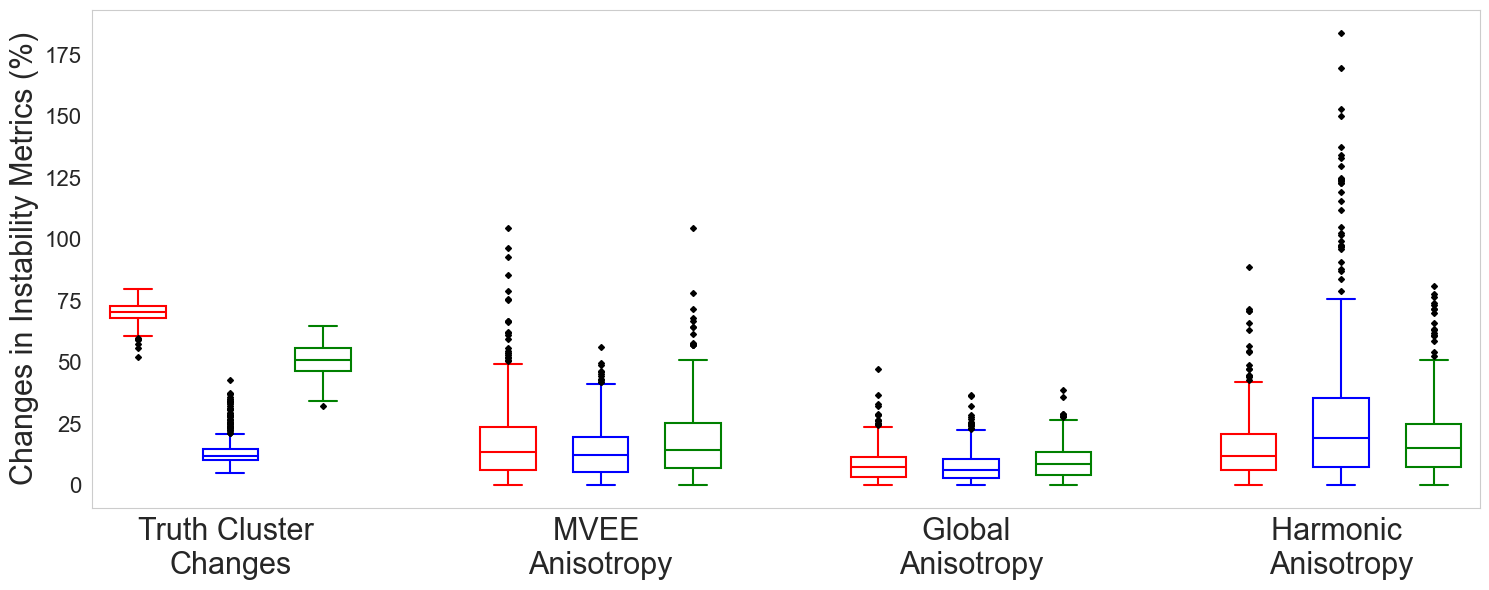

In [3]:
pickle_file1 = os.getcwd() + '\Data Files' + '\instability_measures_corr_0.pkl'
with open(pickle_file1, 'rb') as file:
    instability_measures_corr_0 = pickle.load(file)

pickle_file2 = os.getcwd() + '\Data Files' + '\instability_measures_wine.pkl'
with open(pickle_file2, 'rb') as file:
    instability_measures_wine = pickle.load(file)

pickle_file3 = os.getcwd() + '\Data Files' + '\instability_measures_corr_1.pkl'
with open(pickle_file3, 'rb') as file:
    instability_measures_corr_1 = pickle.load(file)

all_dicts = [instability_measures_corr_0, instability_measures_wine, instability_measures_corr_1]
compare_boxplot(dictionary_list=all_dicts, y_label='Changes in Instability Metrics (%)')

## Modified Functions In Use

In [4]:
def compare_kde(dictionary, x_label, bandwidth='scott'):

    # Make fig
    fig, ax = plt.subplots(figsize=(5, 3))
    colors = ['red', 'blue', 'green']
    #lines = [':', '--', '-']
    lines = ['--', '-', '-.']
    for idx, (label, values) in enumerate(dictionary.items()):
        sns.kdeplot(values, ax=ax, label=label, bw_method=bandwidth, color=colors[idx % len(colors)], lw=1.0, linestyle=lines[idx % len(lines)])

    # Aesthetics
    ax.set_xlabel(x_label, fontsize=10)
    ax.set_ylabel('Density', fontsize=10)
    ax.tick_params(axis='both', labelsize=8)
    # ax.legend(loc='upper center',  bbox_to_anchor=(0.5, -0.23), ncol=len(data_kde), fontsize=9) # fancybox=True, shadow=True,
    ax.legend(loc='best', fontsize=8)
    plt.tight_layout()
    plt.savefig('Comparative KDE Plots ' + x_label + '.tiff', dpi=300, bbox_inches='tight')
    plt.show()
    return

In [5]:
def compare_boxplot(dictionary_list, y_label, custom_xlabels):

    # Data prep
    variable_names = list(dictionary_list[0].keys()) # Extract variable names from any of the dictionaries
    data_for_plot = {variable: [d[variable] for d in dictionary_list] for variable in variable_names}

    # Plotting Customizations
    colors = ['red', 'blue', 'green'] # Colors for data dictionaries
    labels = ['Low Correlation', 'Wine Dataset', 'Moderately-High Correlation']  # Labels for legend
    line_width = 1.5  # Uniform line width
    gap = 1.0  # Gap between groups of variables, 1.5
    outlier_marker = {"marker": "D", "markerfacecolor": "black", "markeredgecolor": "black", "markersize": 3}

    ## Make figure
    fig, ax = plt.subplots(figsize=(15, 6))  # Adjusted figure size (15,6 )for 5variables for 4 variables ()

    n_dicts = len(dictionary_list) # Grab positions
    n_variables = len(variable_names)
    positions = []

    for i in range(n_variables):
        start = i * (n_dicts + gap)
        positions.extend([start + j for j in range(n_dicts)])

    # Make box plots
    for idx, (variable, values) in enumerate(data_for_plot.items()):
        for i, value in enumerate(values):
            box = ax.boxplot(value, positions=[positions[idx * n_dicts + i]], widths=0.6, patch_artist=True,
                       boxprops=dict(facecolor='none', color=colors[i % len(colors)], linewidth=line_width),
                       whiskerprops=dict(color=colors[i % len(colors)], linewidth=line_width),
                       capprops=dict(color=colors[i % len(colors)], linewidth=line_width),
                       medianprops=dict(color=colors[i % len(colors)], linewidth=line_width),
                       flierprops=outlier_marker
                       )

    # Create custom legend with lines
    legend_handles = [mlines.Line2D([], [], color=color, linewidth=line_width, label=label) for color, label in zip(colors, labels)]
    ax.legend(handles=legend_handles, loc='upper left', fontsize=16)

    # Aesthetics
    ax.set_xticks([(n_dicts - 1) / 2 + i * (n_dicts + gap) for i in range(n_variables)])
    ax.set_xticklabels(custom_xlabels, fontsize=22)
    ax.tick_params(axis='y', labelsize=16)
    ax.set_ylabel(y_label, fontsize=22)
    plt.tight_layout()
    plt.savefig('Comparative Instability Measures Box Plots.tiff', dpi=300, bbox_inches='tight')
    plt.show()
    return

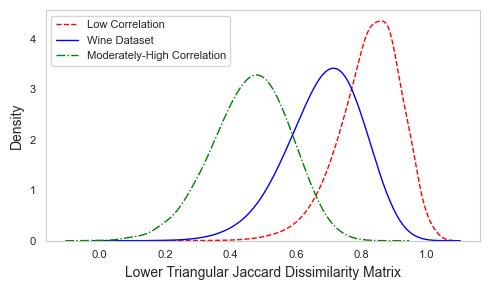

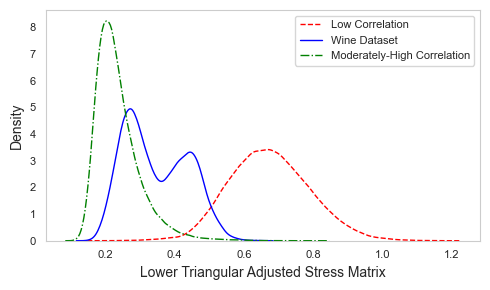

In [6]:
compare_kde(jaccard_dictionary, x_label='Lower Triangular Jaccard Dissimilarity Matrix', bandwidth=0.3)
compare_kde(stress_dictionary, x_label='Lower Triangular Adjusted Stress Matrix')

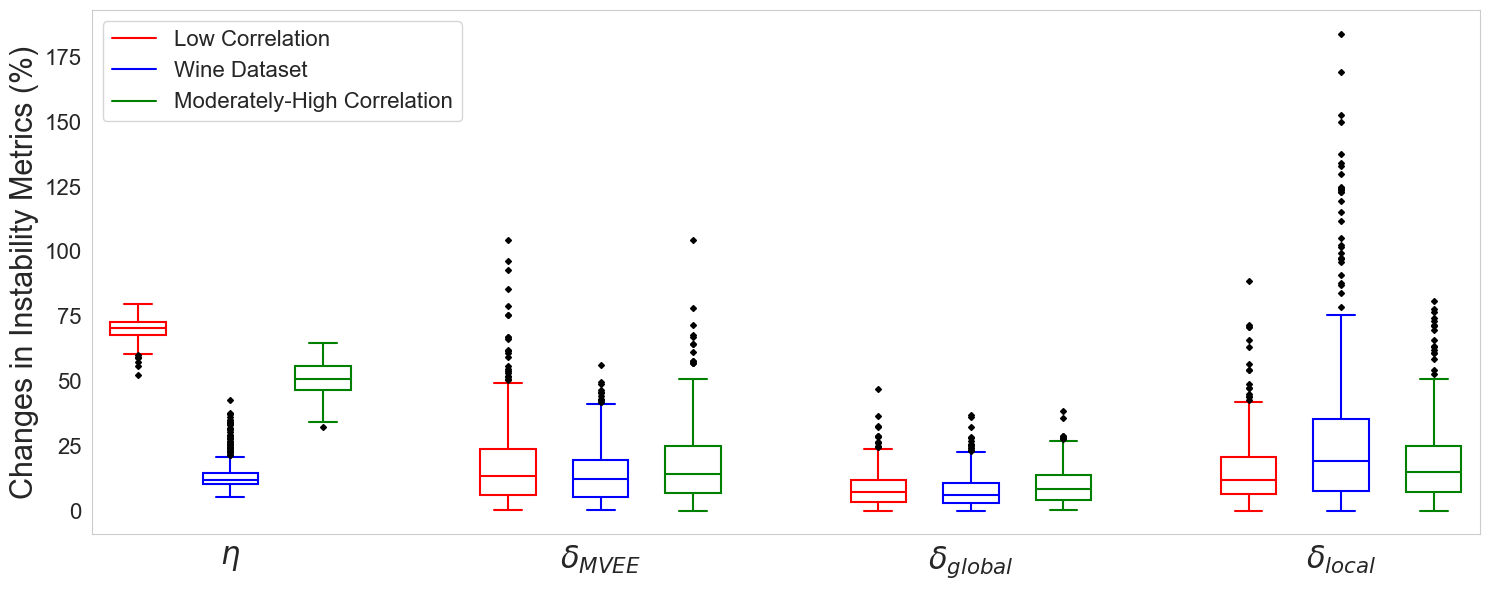

In [7]:
#custom_xlabels = [r'$\eta$ (%)', r'$\delta_{MVEE}$ (%)', r'$\delta_{global}$ (%)', r'$\delta_{local}$ (%)']
custom_xlabels = [r'$\eta$', r'$\delta_{MVEE}$', r'$\delta_{global}$', r'$\delta_{local}$']
compare_boxplot(dictionary_list=all_dicts, y_label='Changes in Instability Metrics (%)', custom_xlabels=custom_xlabels)